In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1. Load the datasets

In [5]:
df_3 = pd.read_csv("Use Case - Onboarding effectiveness - 3 months data.csv")
df_6 = pd.read_csv("Use Case - Onboarding Effectiveness - 6 months data.csv")

In [6]:
df_3.info(), df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7014 entries, 0 to 7013
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           7014 non-null   int64  
 1   ID                   7014 non-null   float64
 2   Reached_3w           7014 non-null   float64
 3   Reached_3m           7014 non-null   float64
 4   Tenure_In_Months     7014 non-null   float64
 5   Date_Joined          7014 non-null   object 
 6   FUA_Balance          7014 non-null   float64
 7   Number_Of_Services   7014 non-null   float64
 8   Has_Payroll          7014 non-null   float64
 9   Income               508 non-null    float64
 10  Has_Investment       7014 non-null   float64
 11  Has_Visa             7014 non-null   float64
 12  VISA_balance         7014 non-null   float64
 13  Has_mortgage         7014 non-null   float64
 14  Has_Deposit          7014 non-null   float64
 15  Number_Transactions  7014 non-null   f

(None, None)

2. Enrich the dataset for proper analysis

In [7]:
# Create age bins
bins = [18, 29, 49, np.inf]
labels = ['Young', 'Middle-aged', 'Senior']

df_3['Age_Bin'] = pd.cut(df_3['Age'], bins=bins, labels=labels)
df_6['Age_Bin'] = pd.cut(df_6['Age'], bins=bins, labels=labels)

# Categorize calls based on "No call", "Called 3W", "Called 3M", "Called Both"
def categorize_calls(week_3, month_3):
    if week_3 == 0 and month_3 == 0:
        return 'No call'
    elif week_3 == 1 and month_3 == 0:
        return 'Called 3w'
    elif week_3 == 0 and month_3 == 1:
        return 'Called 3m'
    else:
        return 'Called both'

df_3['Call_Category'] = df_3.apply(lambda row: categorize_calls(row['Reached_3w'], row['Reached_3m']), axis=1)
df_6['Call_Category'] = df_6.apply(lambda row: categorize_calls(row['Reached_3w'], row['Reached_3m']), axis=1)

In [8]:
# Assign Customer Value Scores

# Define weights for each indicator (weighted equally for now, normalize for visa balance and number of transactions)
weights = {
    'Has_Visa': 1,
    'Has_Investment': 1,
    'VISA_balance': 1,
    'Has_mortgage': 1,
    'Has_Deposit': 1,
    'Number_Transactions': 1
}

def compute_value_score(df):
    return (
        weights['Has_Visa'] * df['Has_Visa'] +
        weights['Has_Investment'] * df['Has_Investment'] +
        weights['VISA_balance'] * df['VISA_balance'] / df['VISA_balance'].max() +
        weights['Has_mortgage'] * df['Has_mortgage'] +
        weights['Has_Deposit'] * df['Has_Deposit'] +
        weights['Number_Transactions'] * df['Number_Transactions'] / df['Number_Transactions'].max()
    )

df_3['Customer_Value_Score'] = compute_value_score(df_3)
df_6['Customer_Value_Score'] = compute_value_score(df_6)

df_3['Customer_Value_Score']

0       1.124654
1       2.331824
2       2.126776
3       2.000000
4       2.693696
          ...   
7009    2.000000
7010    3.045965
7011    2.000000
7012    2.574463
7013    2.002770
Name: Customer_Value_Score, Length: 7014, dtype: float64

3. Aggregate and Calculate Incremental Customer Value Score to assess the impact of calling and not calling at all.

3.1 Aggregate everything

In [9]:
no_call_avg_value_3m = df_3[df_3['Call_Category'] == 'No call']['Customer_Value_Score'].mean()
df_3['Incremental_Value_3m'] = df_3['Customer_Value_Score'] - no_call_avg_value_3m

no_call_avg_value_6m = df_6[df_6['Call_Category'] == 'No call']['Customer_Value_Score'].mean()
df_6['Incremental_Value_6m'] = df_6['Customer_Value_Score'] - no_call_avg_value_6m

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1986567764.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g_3m_no_age_no_payroll = sns.catplot(data=df_3,
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

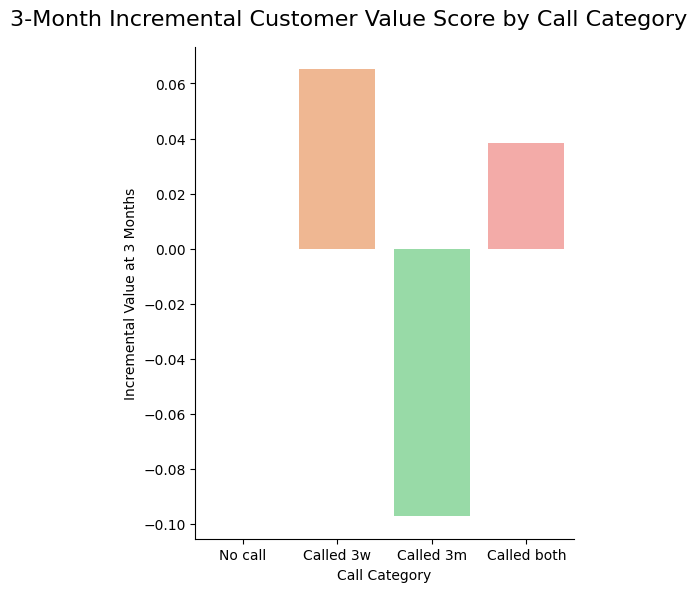

In [10]:
call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']

# Plotting the Incremental Value for 3-month data
g_3m_no_age_no_payroll = sns.catplot(data=df_3,
                                     x='Call_Category', y='Incremental_Value_3m',
                                     palette="pastel", kind="bar", ci=None, order=call_order, height=6, aspect=0.8)
#g_3m_no_age_no_payroll.fig.subplots_adjust(top=0.9)
g_3m_no_age_no_payroll.fig.suptitle('3-Month Incremental Customer Value Score by Call Category', fontsize=16)
g_3m_no_age_no_payroll.set_axis_labels('Call Category', 'Incremental Value at 3 Months')
plt.tight_layout()
plt.show()

/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/3498515710.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g_6m_no_age_no_payroll = sns.catplot(data=df_6,
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

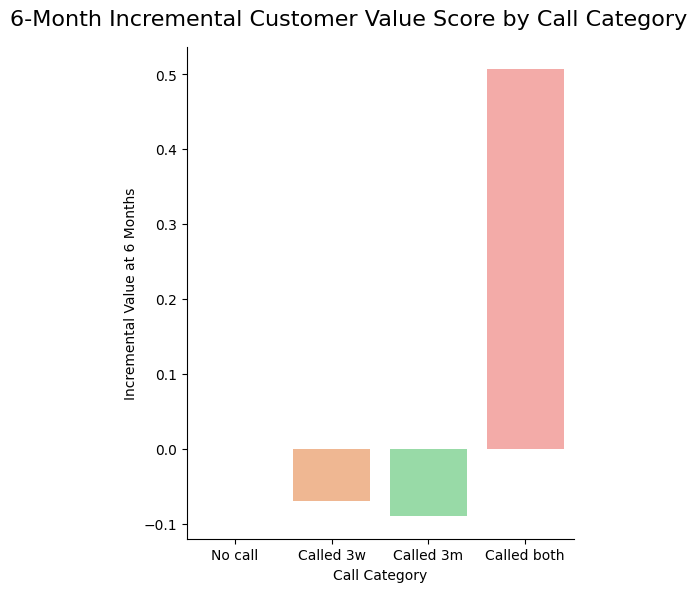

In [11]:
# Plotting the Incremental Value for 6-month data
g_6m_no_age_no_payroll = sns.catplot(data=df_6,
                                     x='Call_Category', y='Incremental_Value_6m',
                                     palette="pastel", kind="bar", ci=None, order=call_order, height=6, aspect=0.8)
#g_6m_no_age_no_payroll.fig.subplots_adjust(top=0.9)
g_6m_no_age_no_payroll.fig.suptitle('6-Month Incremental Customer Value Score by Call Category', fontsize=16)
g_6m_no_age_no_payroll.set_axis_labels('Call Category', 'Incremental Value at 6 Months')
plt.tight_layout()
plt.show()

3.2 Aggregate based on Payroll

In [12]:
# Calculate the average Customer Value Score for the 'No call' category considering 'Has_Payroll' and 'No_Payroll'
no_call_avg_values_3m = df_3[df_3['Call_Category'] == 'No call'].groupby('Has_Payroll')['Customer_Value_Score'].mean()
no_call_avg_values_6m = df_6[df_6['Call_Category'] == 'No call'].groupby('Has_Payroll')['Customer_Value_Score'].mean()

no_call_avg_values_3m, no_call_avg_values_6m

(Has_Payroll
 0.0    2.17038
 1.0    2.46196
 Name: Customer_Value_Score, dtype: float64,
 Has_Payroll
 0    2.142046
 1    2.418165
 Name: Customer_Value_Score, dtype: float64)

In [13]:
# Compute the Incremental_Value for each row based on its Has_Payroll value
df_3['Incremental_Value_3m'] = df_3.apply(lambda row: row['Customer_Value_Score'] - no_call_avg_values_3m[row['Has_Payroll']], axis=1)
df_6['Incremental_Value_6m'] = df_6.apply(lambda row: row['Customer_Value_Score'] - no_call_avg_values_6m[row['Has_Payroll']], axis=1)

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/2995239187.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_3, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remo

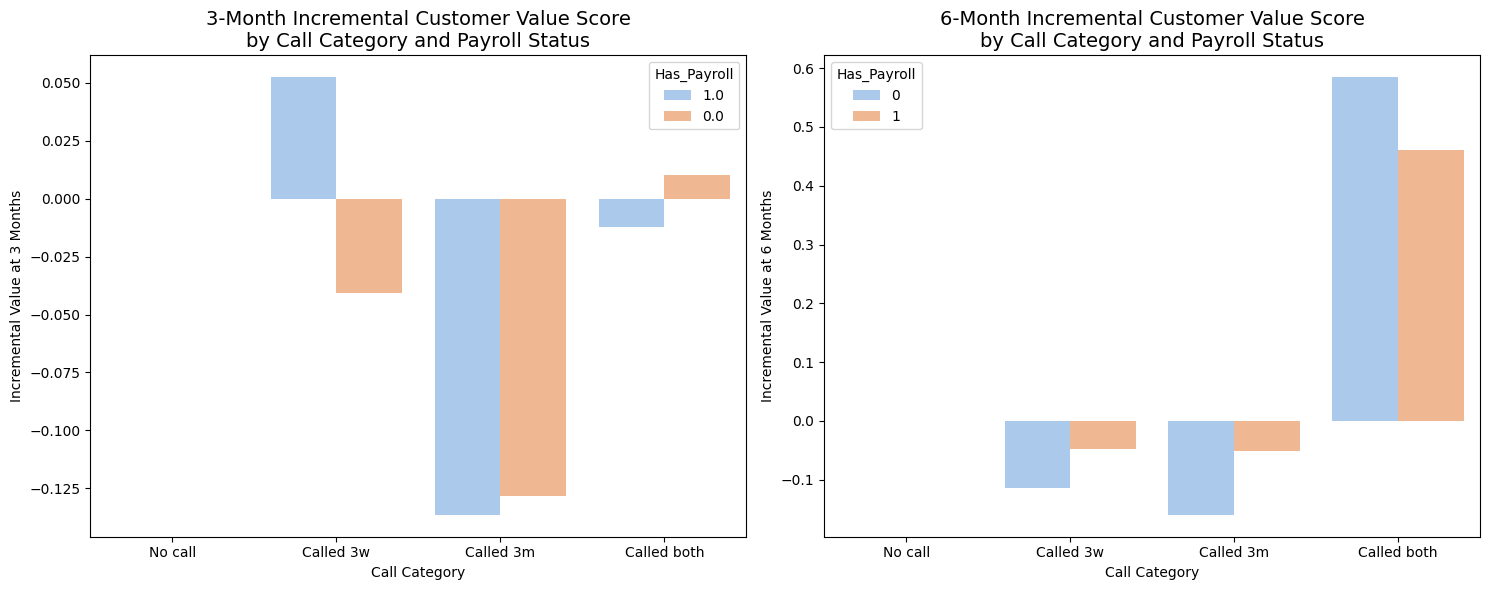

In [15]:
# Plotting
call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']
df_3['Has_Payroll'] = df_3['Has_Payroll'].astype(str)
df_6['Has_Payroll'] = df_6['Has_Payroll'].astype(str)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for 3-month data
sns.barplot(data=df_3, ax=axes[0],
            x='Call_Category', y='Incremental_Value_3m', hue='Has_Payroll',
            palette="pastel", ci = None, order=call_order)
axes[0].set_title('3-Month Incremental Customer Value Score\nby Call Category and Payroll Status', fontsize=14)
axes[0].set_xlabel('Call Category')
axes[0].set_ylabel('Incremental Value at 3 Months')

# Plotting for 6-month data
sns.barplot(data=df_6, ax=axes[1],
            x='Call_Category', y='Incremental_Value_6m', hue='Has_Payroll',
            palette="pastel", ci = None, order=call_order)
axes[1].set_title('6-Month Incremental Customer Value Score\nby Call Category and Payroll Status', fontsize=14)
axes[1].set_xlabel('Call Category')
axes[1].set_ylabel('Incremental Value at 6 Months')

plt.tight_layout()
plt.show()


In [16]:
df_3

,Unnamed: 0,ID,Reached_3w,Reached_3m,Tenure_In_Months,Date_Joined,FUA_Balance,Number_Of_Services,Has_Payroll,Income,...,Has_mortgage,Has_Deposit,Number_Transactions,Age,City,Unnamed: 17,Age_Bin,Call_Category,Customer_Value_Score,Incremental_Value_3m
0,0,2613.0,0.0,0.0,3.0,7/15/2020,944.35,2.0,1.0,NaN,...,0.0,1.0,45.0,49.0,SURREY ...,NaN,Middle-aged,No call,1.124654,-1.337306
1,1,3382.0,1.0,1.0,3.0,1/21/2021,1589.61,2.0,0.0,NaN,...,0.0,1.0,25.0,69.0,PENDER ISLAND ...,NaN,Senior,Called both,2.331824,0.161444
2,2,3927.0,1.0,1.0,3.0,8/14/2020,1000.00,3.0,1.0,NaN,...,0.0,1.0,0.0,59.0,BURNABY ...,NaN,Senior,Called both,2.126776,-0.335184
3,3,4065.0,1.0,1.0,3.0,6/26/2020,219.41,1.0,0.0,NaN,...,0.0,1.0,0.0,71.0,VANCOUVER ...,NaN,Senior,Called both,2.000000,-0.170380
4,4,4221.0,0.0,0.0,3.0,12/18/2020,76.09,1.0,0.0,NaN,...,0.0,1.0,66.0,65.0,VANCOUVER ...,NaN,Senior,No call,2.693696,0.523316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7009,7009,9996256.0,1.0,0.0,3.0,1/19/2021,710077.85,2.0,0.0,NaN,...,0.0,1.0,0.0,72.0,RICHMOND ...,NaN,Senior,Called 3w,2.000000,-0.170380
7010,7010,9998431.0,1.0,0.0,3.0,12/19/2020,2495.02,2.0,1.0,NaN,...,0.0,1.0,23.0,66.0,VANCOUVER ...,NaN,Senior,Called 3w,3.045965,0.584006
7011,7011,9999175.0,1.0,0.0,3.0,3/23/2020,10.00,1.0,1.0,NaN,...,0.0,1.0,0.0,59.0,PITT MEADOWS ...,NaN,Senior,Called 3w,2.000000,-0.461960
7012,7012,9999557.0,0.0,0.0,3.0,7/28/2020,463505.54,2.0,0.0,NaN,...,0.0,1.0,8.0,58.0,SURREY ...,NaN,Senior,No call,2.574463,0.404083


3.2 Aggregate based on Payroll and Age

In [17]:
# Calculate the average Customer Value Score for the 'No call' category
# considering 'Has_Payroll', 'No_Payroll' and 'Age_Bin'
no_call_avg_values_3m = df_3[df_3['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value_Score'].mean()
no_call_avg_values_6m = df_6[df_6['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value_Score'].mean()

no_call_avg_values_3m, no_call_avg_values_6m


/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1889608106.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_3m = df_3[df_3['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value_Score'].mean()
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1889608106.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_call_avg_values_6m = df_6[df_6['Call_Category'] == 'No call'].groupby(['Has_Payroll', 'Age_Bin'])['Customer_Value_Score'].mean()


(Has_Payroll  Age_Bin    
 0.0          Young          2.135869
              Middle-aged    2.194216
              Senior         2.156258
 1.0          Young          2.496449
              Middle-aged    2.565287
              Senior         2.412162
 Name: Customer_Value_Score, dtype: float64,
 Has_Payroll  Age_Bin    
 0            Young          2.191841
              Middle-aged    2.138982
              Senior         2.142940
 1            Young          2.548069
              Middle-aged    2.528396
              Senior         2.363668
 Name: Customer_Value_Score, dtype: float64)

In [18]:
# Compute the Incremental_Value for each row based on its Has_Payroll and Age_Bin values
df_3['Incremental_Value_3m'] = df_3.apply(lambda row: row['Customer_Value_Score'] - no_call_avg_values_3m[(row['Has_Payroll'], row['Age_Bin'])], axis=1)
df_6['Incremental_Value_6m'] = df_6.apply(lambda row: row['Customer_Value_Score'] - no_call_avg_values_6m[(row['Has_Payroll'], row['Age_Bin'])], axis=1)


/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1471336555.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=subset_3, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be 

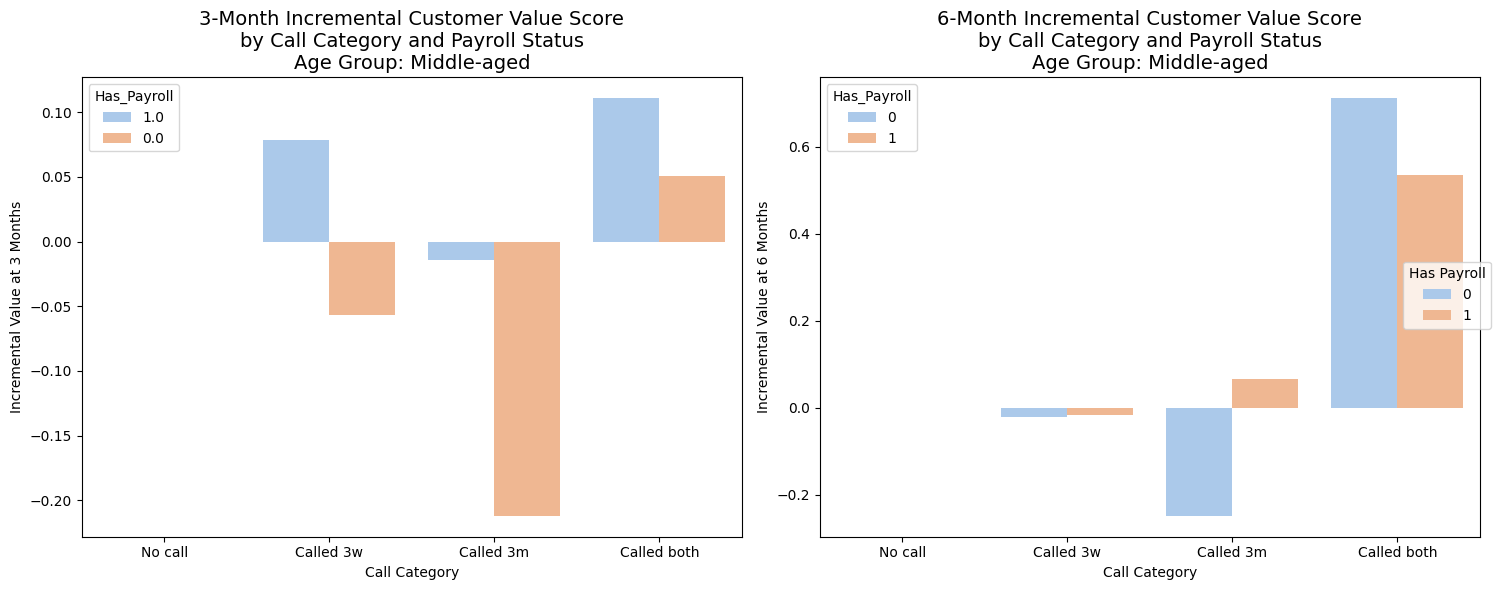

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1471336555.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=subset_3, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be 

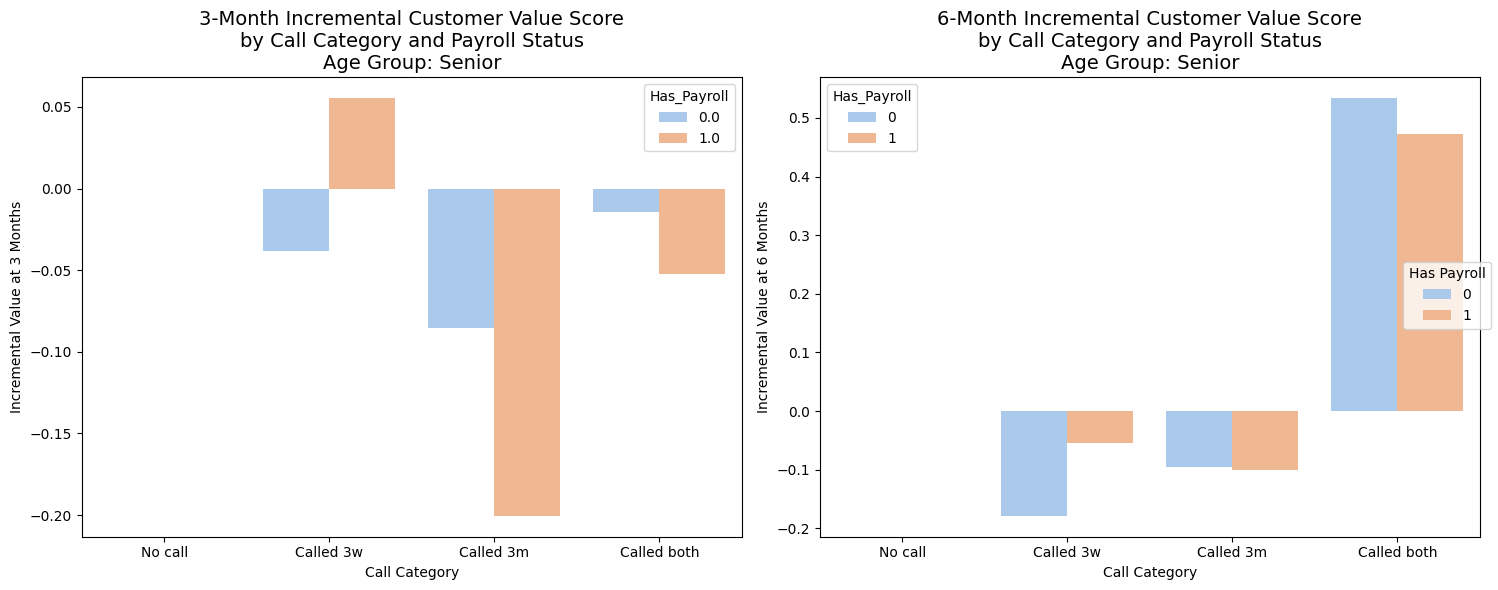

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_25764/1471336555.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=subset_3, ax=axes[0],
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jonathanau/Desktop/SFU_MPCS/CMPT889/A1/CMPT889_A1/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be 

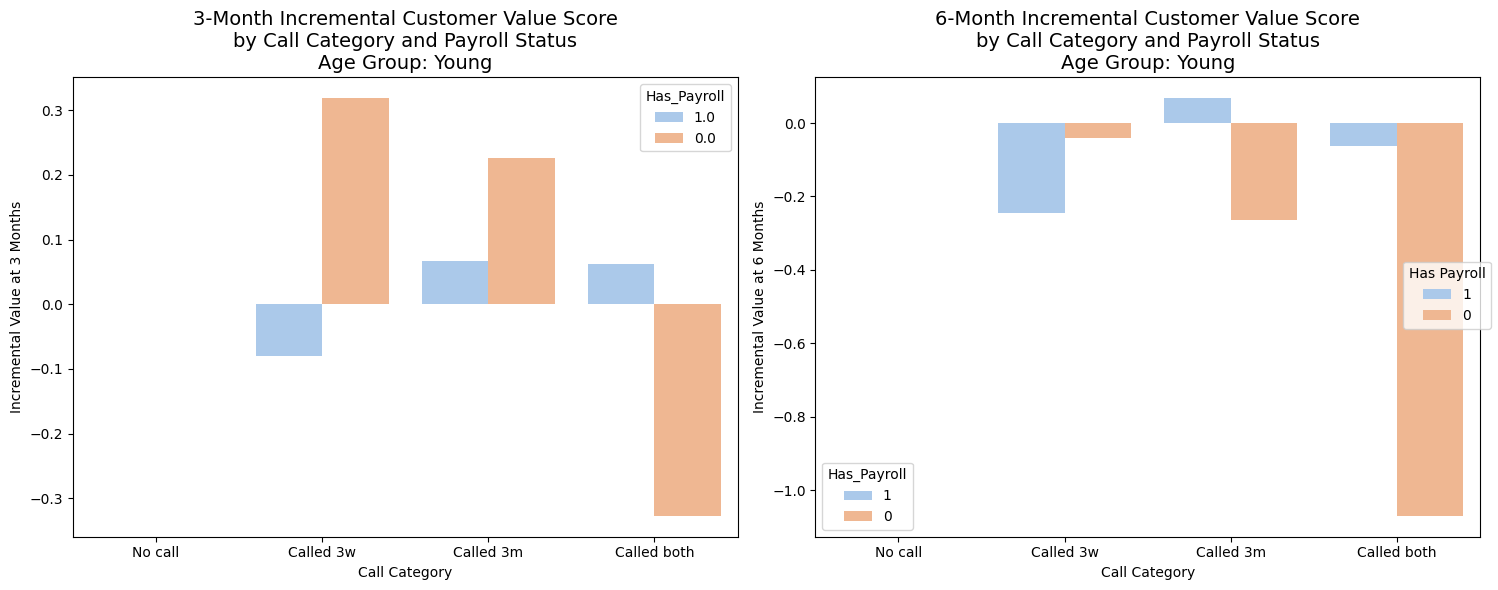

In [19]:
call_order = ['No call', 'Called 3w', 'Called 3m', 'Called both']
age_bins = df_3['Age_Bin'].unique()

for age_bin in age_bins:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plotting for 3-month data
    subset_3 = df_3[df_3['Age_Bin'] == age_bin]
    sns.barplot(data=subset_3, ax=axes[0],
                x='Call_Category', y='Incremental_Value_3m', hue='Has_Payroll',
                palette="pastel", ci=None, order=call_order)
    axes[0].set_title(f'3-Month Incremental Customer Value Score\nby Call Category and Payroll Status\nAge Group: {age_bin}', fontsize=14)
    axes[0].set_xlabel('Call Category')
    axes[0].set_ylabel('Incremental Value at 3 Months')

    # Plotting for 6-month data
    subset_6 = df_6[df_6['Age_Bin'] == age_bin]
    sns.barplot(data=subset_6, ax=axes[1],
                x='Call_Category', y='Incremental_Value_6m', hue='Has_Payroll',
                palette="pastel", ci=None, order=call_order)
    axes[1].set_title(f'6-Month Incremental Customer Value Score\nby Call Category and Payroll Status\nAge Group: {age_bin}', fontsize=14)
    axes[1].set_xlabel('Call Category')
    axes[1].set_ylabel('Incremental Value at 6 Months')

    # Adjust legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, title='Has Payroll', loc='center right')

    plt.tight_layout()
    plt.show()
